# Where to go? -- Uber Movement 資料分析

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
import fiona
from shapely.geometry import shape
import networkx as nx
import random
import community

In [483]:
class UberData(object):
    def __init__(self, datafile, mapfile, max_zone, level):
        super(UberData, self).__init__()
        self.datafile = datafile
        self.mapfile = mapfile
        self.max_zone = max_zone
        self.level = level
        self.data = self.process_file()
        self.mean_matrix = self.build_matrix()
        self.df_place = self.build_df()
        self.outward, self.inward = self.build_io()
    
    def process_file(self):
        data = []
        with open(self.datafile, 'r') as f:
            lines = f.readlines()
            for l in lines[1:]:
                splitted = tuple([float(x) for x in l[:-1].split(',')])
                data.append(splitted)
        data = np.array(data)
        return data
    
    def build_matrix(self):
        mean_matrix = np.zeros((self.level, self.max_zone, self.max_zone))
        for d in self.data:
            src, tgt = int(d[0]), int(d[1])
            stage = int(d[2]) if self.level == 24 else int(d[2])-1
            if src <= self.max_zone and tgt <= self.max_zone:
                mean_matrix[stage][src-1][tgt-1] = d[3]
        return mean_matrix
    
    def build_df(self):
        df_place = gpd.read_file(self.mapfile)
        df_place['zone'] = df_place.DISPLAY_NAME.apply(lambda x: int(x[5:]))
        df = df_place[df_place['zone'] <= self.max_zone]
        return df
        
    def heatmap(self, stage):
        sns.heatmap(self.mean_matrix[stage])
        plt.show()
    
    def build_io(self):
        inward = np.zeros((self.level, self.max_zone))
        outward = np.zeros((self.level, self.max_zone))
        for d in self.data:
            src, tgt= int(d[0]), int(d[1])
            stage = int(d[2]) if self.level == 24 else int(d[2])-1
            if src <= self.max_zone and tgt <= self.max_zone:
                outward[stage][src-1] += 1
                inward[stage][tgt-1] += 1
        return outward, inward
    
    def plot_demand(self, hour):
        if 'demand_' + str(hour) not in self.df_place:
            diff = 2*(self.outward[hour]) - (self.inward[hour])
            self.df_place['demand_'+str(hour)] = self.df_place.zone.apply(lambda x: diff[x-1])
        self.df_place.plot(column='demand_'+str(hour), cmap='coolwarm')
    
    def save_demand(self, hour, dirname):
        if hour < 10:
            plt.savefig(dirname+'/demand_0'+str(hour))
        else:
            plt.savefig(dirname+'/demand_'+str(hour))

In [5]:
all_2016q4 = UberData('./data/taipei-taz-2016-4-All-HourlyAggregate.csv', './taipei_taz.json', 300, 24)

In [484]:
weekday_2016q4 = UberData('./data/taipei-taz-2016-4-OnlyWeekdays-HourlyAggregate.csv', './taipei_taz.json', 300, 24)

In [485]:
weekend_2016q4 = UberData('./data/taipei-taz-2016-4-OnlyWeekends-HourlyAggregate.csv', './taipei_taz.json', 300, 24)

In [185]:
weekday_2016q4.df_place['outward_3'] = weekday_2016q4.outward[3]
weekday_2016q4.df_place['inward_3'] = weekday_2016q4.inward[3]

In [199]:
weekday_2016q4.df_place['outward_9'] = weekday_2016q4.outward[9]

In [513]:
plt.rcParams['figure.figsize'] = [10, 8]

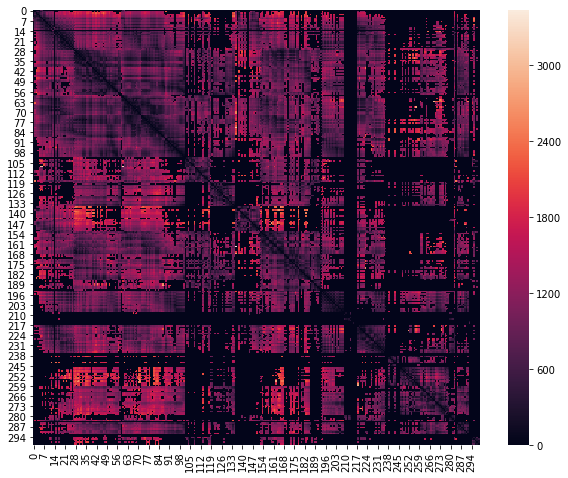

In [514]:
sns.heatmap(weekday_2016q4.mean_matrix[11])

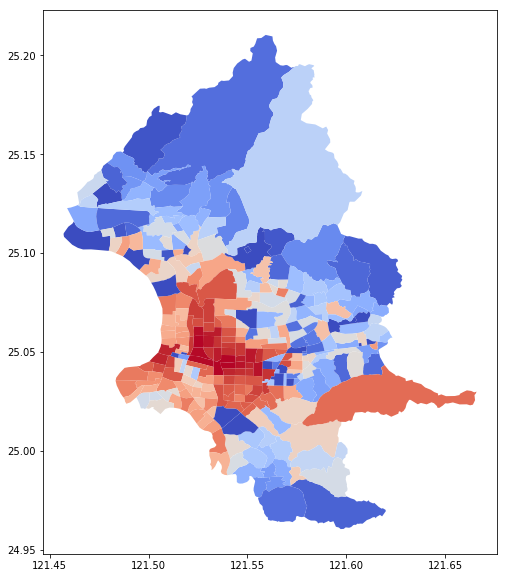

In [198]:
weekday_2016q4.df_place.plot(column='outward_3', cmap='coolwarm')

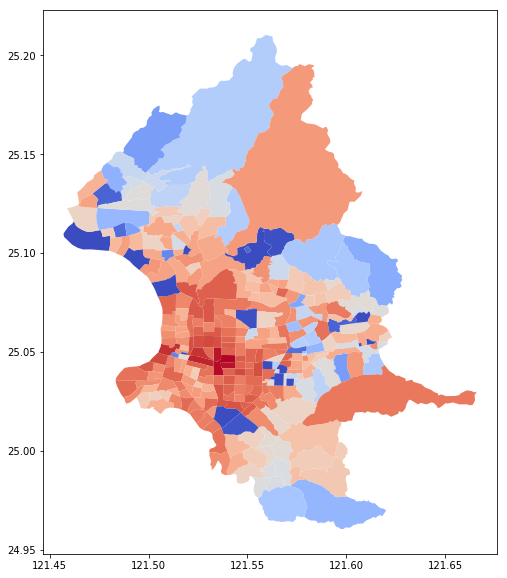

In [200]:
weekday_2016q4.df_place.plot(column='outward_9', cmap='coolwarm')

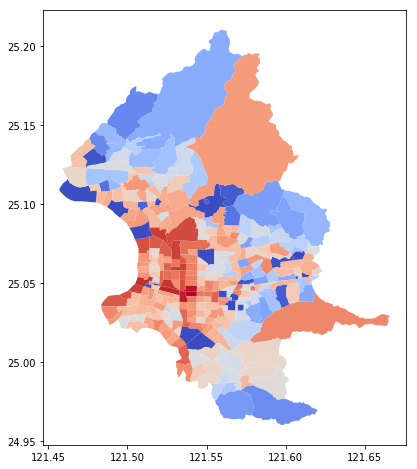

In [187]:
weekday_2016q4.df_place.plot(column='inward_3', cmap='coolwarm')

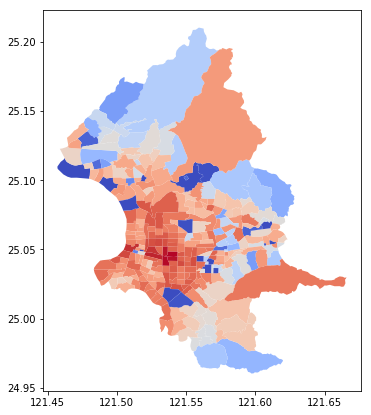

In [287]:
weekday_2016q4.df_place.plot(column='outward_9', cmap='coolwarm')

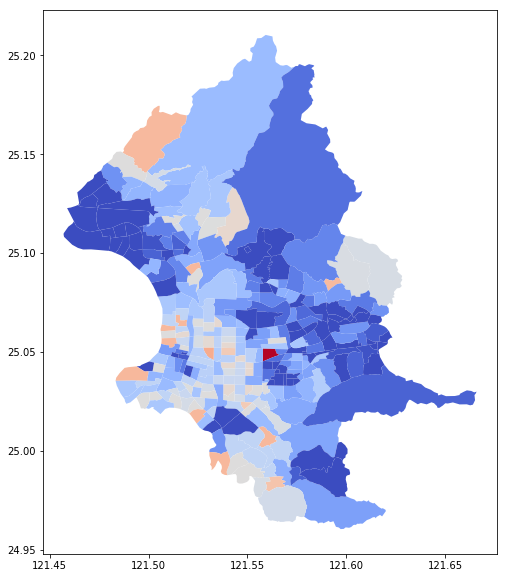

In [684]:
weekday_2016q4.df_place.plot(column='cc', cmap='coolwarm')

In [683]:
weekday_2016q4.df_place['cc'] = cc.values()

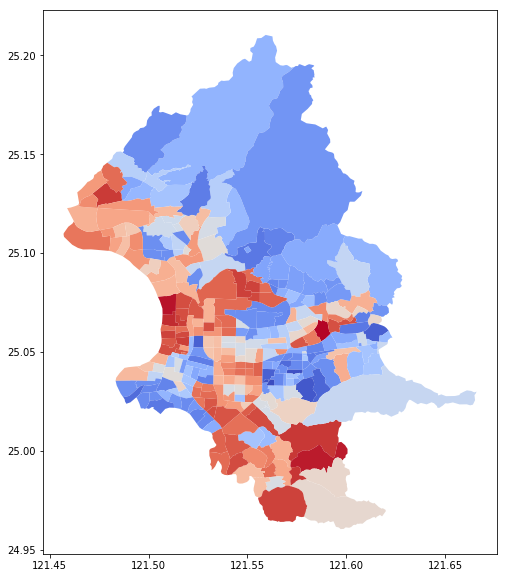

In [490]:
weekday_2016q4.plot_demand(3)

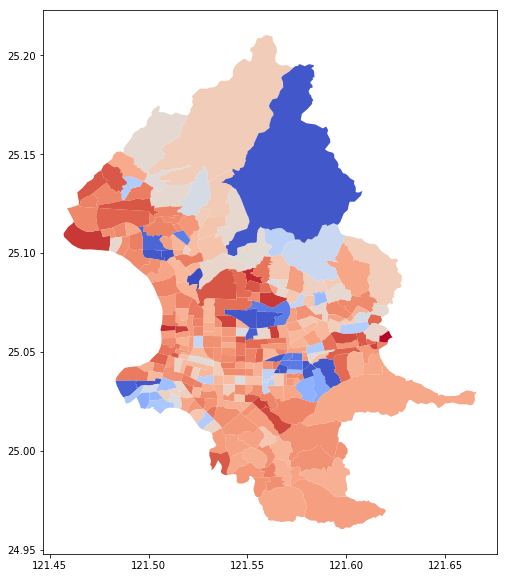

In [491]:
weekday_2016q4.plot_demand(9)

In [486]:
plt.rcParams['figure.figsize'] = [10, 10]

In [92]:
df_small.to_file('./taipei_taz_small.json')

/home/hsjma/anaconda3/envs/lab/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [268]:
def normalize(mat):
    ran = mat.max() - mat.min()
    return (mat - mat.min())/ran

In [276]:
def diffmat(mat1, mat2):
    return (np.square(mat1 - mat2)).sum()

In [434]:
print(diffmat(normalize(test), normalize(test_out)))
print(diffmat(normalize(test), normalize(np.sqrt(test_out+1) - np.sqrt(test_in+1))))
print(diffmat(normalize(test), normalize(2*(test_out+1) - (test_in+1))))

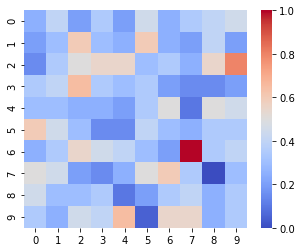

In [480]:
sns.heatmap(normalize(test), cmap='coolwarm')

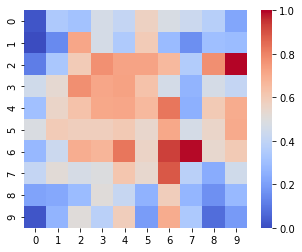

In [481]:
sns.heatmap(normalize(test_out), cmap='coolwarm')

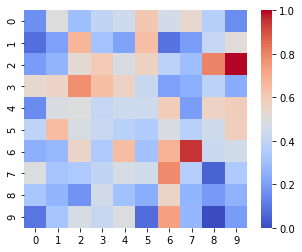

In [482]:
sns.heatmap(normalize(2*(test_out+1) - (test_in+1)), cmap='coolwarm')

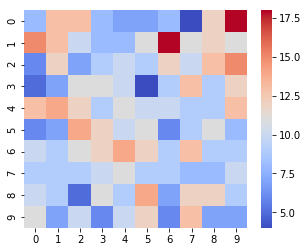

In [263]:
sns.heatmap(test, cmap='coolwarm')

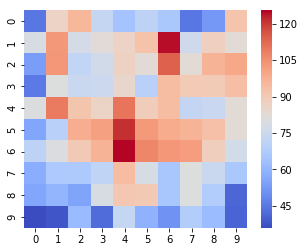

In [264]:
sns.heatmap(test_out, cmap='coolwarm')

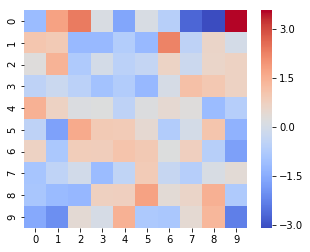

In [265]:
sns.heatmap(np.sqrt(test_out+1) - np.sqrt(test_in+1), cmap='coolwarm')

In [475]:
m = 10
n_sample = 1000

test = np.zeros((m, m))
axis = [np.random.randint(2) for x in range(n_sample)]
pairs = [(np.random.randint(m), random.sample(range(m), k=2)) for x in range(n_sample)]
test_out = np.zeros((m, m))
test_in = np.zeros((m, m))

for i in range(n_sample):
    row, (start, end) = pairs[i]
    if axis[i] == 0:
        test[row][start] += 1
    else:
        test[start][row] += 1

for i in range(n_sample):
    row, (start, end) = pairs[i]
    delta = abs(start - end)
    if axis[i] == 0:
        test_out[row][start] += delta
        test_in[row][end] += delta
        shift = 1 if end > start else -1
        delta -= 1
        while delta != 0:
            start += shift
            end -= shift
            test_out[row][start] += np.sqrt(delta)
            test_in[row][end] += np.sqrt(delta)
            delta -= 1
    else:
        test_out[start][row] += delta
        test_in[end][row] += delta
        shift = 1 if end > start else -1
        delta -= 1
        while delta != 0:
            start += shift
            end -= shift
            test_out[start][row] += np.sqrt(delta)
            test_in[end][row] += np.sqrt(delta)
            delta -= 1

In [476]:
print(diffmat(normalize(test), normalize(test_out)))
print(diffmat(normalize(test), normalize(np.sqrt(test_out+1) - np.sqrt(test_in+1))))
print(diffmat(normalize(test), normalize(2*(test_out+1) - (test_in+1))))

5.445819924369022
4.180359615775398
2.5318576002159605


## Creating a Network

In [148]:
# Converts a shapefile located at indir/infile to a networkx graph.
# If draw_graph is set to True, the graph is drawn using matplotlib.
def create_graph(indir, infile, draw_shapefile=False, draw_graph=False):
    G = nx.Graph()
    i = 1
    
#     with cd(indir):
    with fiona.open(infile) as blocks:
        for shp in blocks:
            # the geometry property here may be specific to my shapefile
            block = shape(shp['geometry'])
            xy = (list(block.centroid.coords)[0][0], list(block.centroid.coords)[0][1])
            G.add_node(i, block=block, xy=xy, zone=shp['properties']['zone'])
            i += 1

    for n in G.nodes(data=True):
        state = n[1]['block']
        for o in G.nodes(data=True):
            other = o[1]['block']
            if state is not other and state.touches(other):
                time3 = weekday_2016q4.mean_matrix[3][n[0]-1][o[0]-1], 
                time9 = weekday_2016q4.mean_matrix[9][n[0]-1][o[0]-1], 
                time18 = weekday_2016q4.mean_matrix[18][n[0]-1][o[0]-1]
                gap3 = round(weekday_2016q4.mean_matrix[3][n[0]-1][o[0]-1] - weekday_2016q4.mean_matrix[3][o[0]-1][n[0]-1])
                gap9 = round(weekday_2016q4.mean_matrix[9][n[0]-1][o[0]-1] - weekday_2016q4.mean_matrix[9][o[0]-1][n[0]-1])
                gap18 = round(weekday_2016q4.mean_matrix[18][n[0]-1][o[0]-1] - weekday_2016q4.mean_matrix[18][o[0]-1][n[0]-1])
                passage3 = int(weekday_2016q4.mean_matrix[3][n[0]-1][o[0]-1] > 0) + int(weekday_2016q4.mean_matrix[3][o[0]-1][n[0]-1] > 0)
                passage9 = int(weekday_2016q4.mean_matrix[9][n[0]-1][o[0]-1] > 0) + int(weekday_2016q4.mean_matrix[9][o[0]-1][n[0]-1] > 0)
                passage18 = int(weekday_2016q4.mean_matrix[18][n[0]-1][o[0]-1] > 0) + int(weekday_2016q4.mean_matrix[18][o[0]-1][n[0]-1] > 0)
                passageall = passage[n[0]-1][o[0]-1]
#                 near = 1 if abs(n[0]-o[0])==1 else 0
                G.add_edge(n[0], o[0], time3=np.log(time3+1), time9=np.log(time9+1), time18=np.log(time18+1), 
                           gap3=gap3, gap9=gap9, gap18=gap18, 
                           passage3=passage3, passage9=passage9, passage18=passage18, passageall=passageall)

    return G

In [163]:
def create_graph1(indir, infile, dataslice, draw_shapefile=False, draw_graph=False):
    G = nx.Graph()
    i = 1
    
#     with cd(indir):
    with fiona.open(infile) as blocks:
        for shp in blocks:
            # the geometry property here may be specific to my shapefile
            block = shape(shp['geometry'])
            xy = (list(block.centroid.coords)[0][0], list(block.centroid.coords)[0][1])
            G.add_node(i, block=block, xy=xy, zone=shp['properties']['zone'])
            i += 1

    for n in G.nodes(data=True):
        state = n[1]['block']
        for o in G.nodes(data=True):
            other = o[1]['block']
            if state is not other and dataslice[n[0]-1][o[0]-1] + dataslice[o[0]-1][n[0]-1] > 0:
                G.add_edge(n[0], o[0], time=(dataslice[n[0]-1][o[0]-1]+dataslice[o[0]-1][n[0]-1])/2)

    return G

In [150]:
gg = create_graph('', './taipei_taz_small/taipei_taz_small.shp', draw_graph=True)

In [164]:
gg3 = create_graph1('', './taipei_taz_small/taipei_taz_small.shp', weekday_2016q4.mean_matrix[3], draw_graph=True)
gg9 = create_graph1('', './taipei_taz_small/taipei_taz_small.shp', weekday_2016q4.mean_matrix[9], draw_graph=True)
gg18 = create_graph1('', './taipei_taz_small/taipei_taz_small.shp', weekday_2016q4.mean_matrix[18], draw_graph=True)

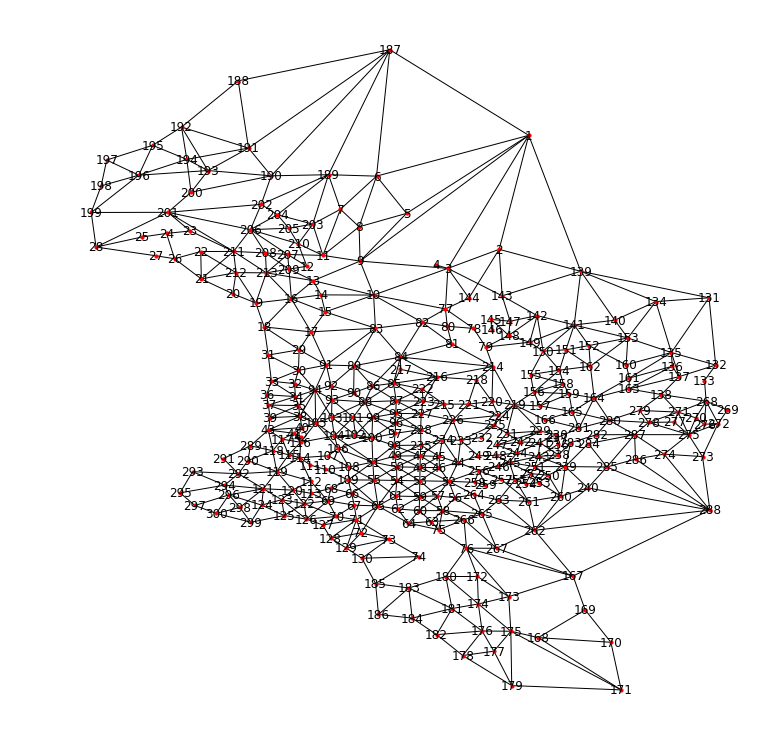

In [492]:
pos = nx.get_node_attributes(gg,'xy')
zone = nx.get_node_attributes(gg, 'zone')
nx.draw(gg, pos=pos, node_size=10)
nx.draw_networkx_labels(gg, pos=pos, labels=zone, )
plt.show()

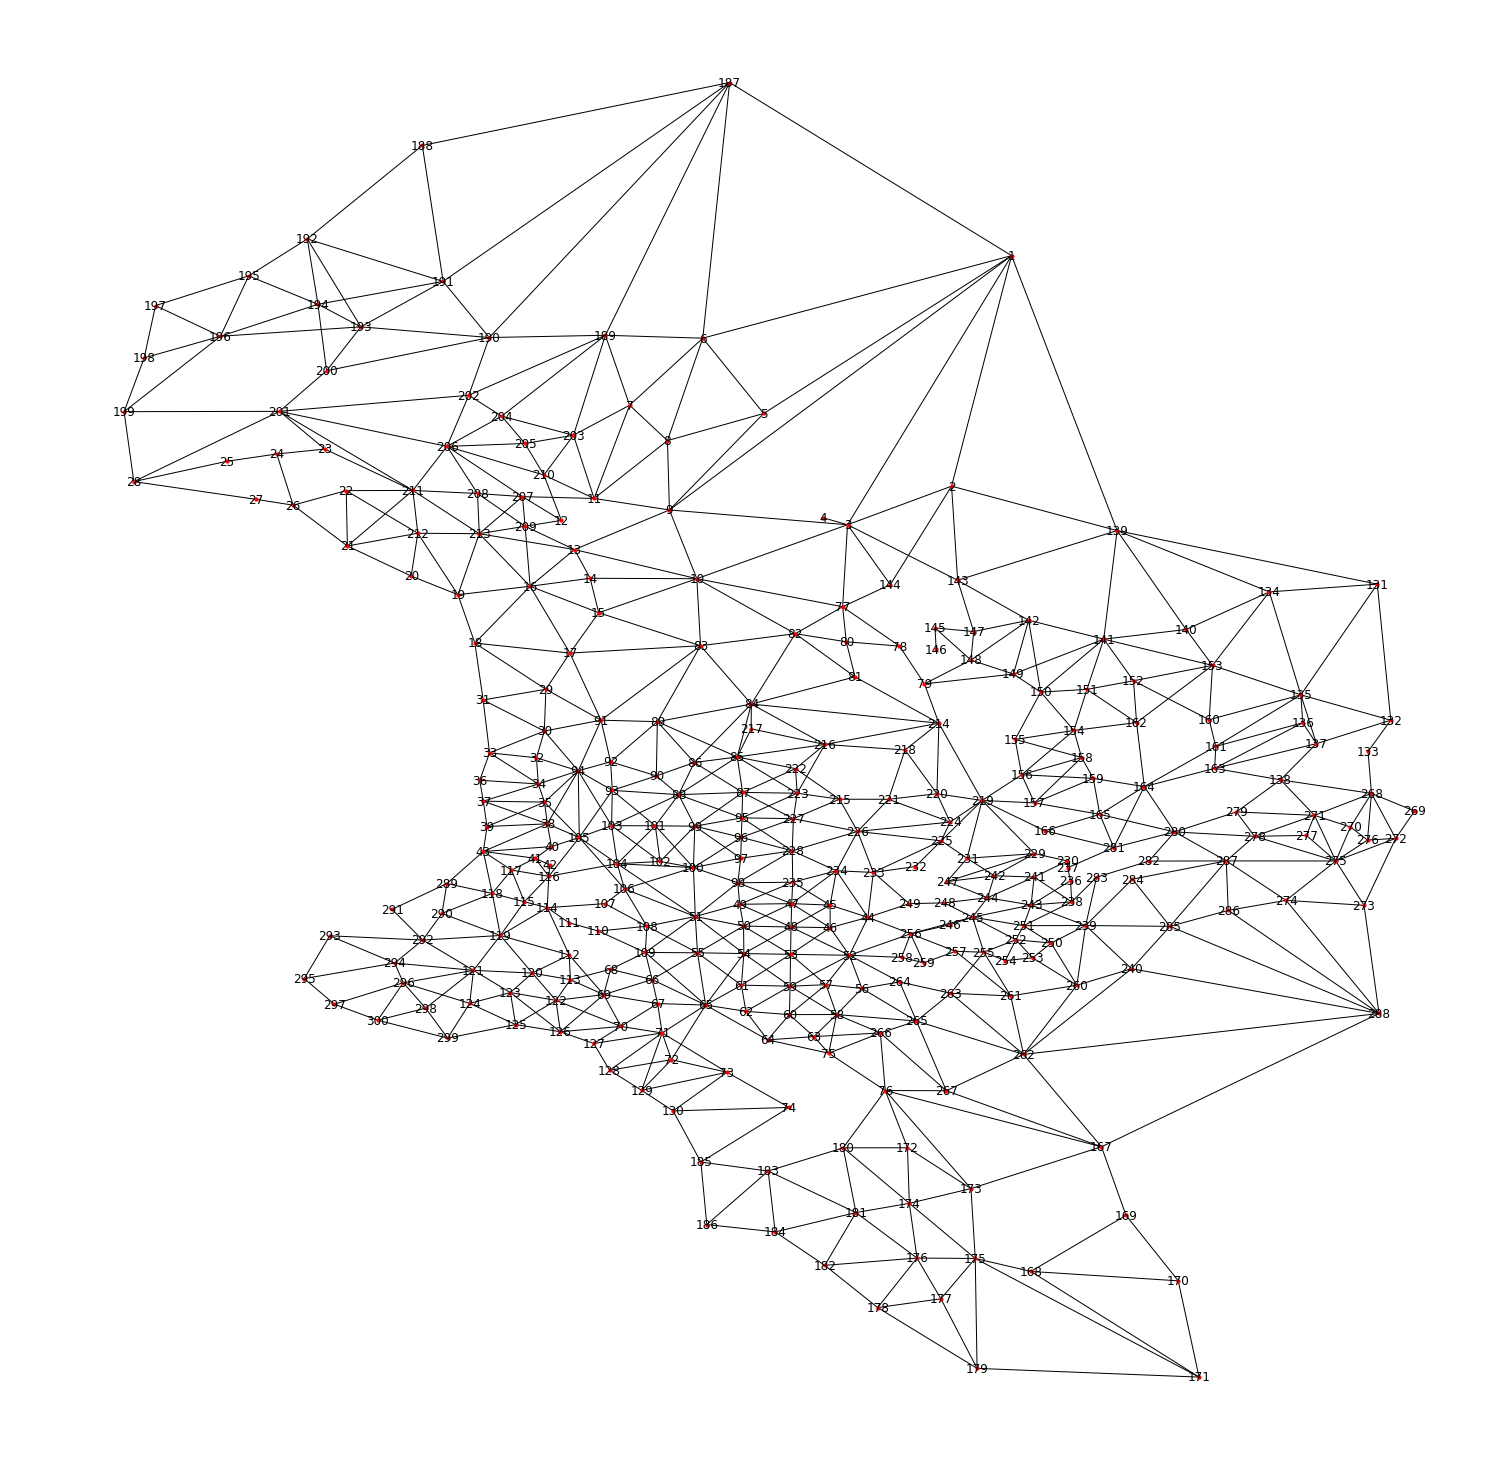

In [462]:
pos = nx.get_node_attributes(gg,'xy')
zone = nx.get_node_attributes(gg, 'zone')
nx.draw(gg, pos=pos, node_size=10)
nx.draw_networkx_labels(gg, pos=pos, labels=zone, )
plt.show()

In [ ]:
nx.shortest_path(gg, 33, 39, weight=)

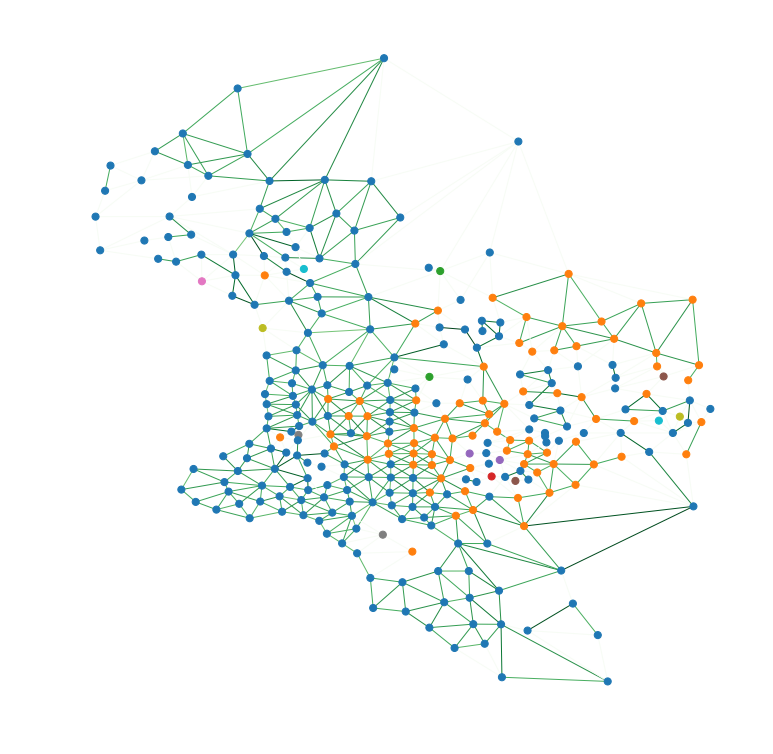

In [177]:
pos = nx.get_node_attributes(gg,'xy')
edges, weights = zip(*nx.get_edge_attributes(gg, 'time3').items())
nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Greens, node_color=list(part3.values()), cmap=plt.cm.tab10)
plt.show()

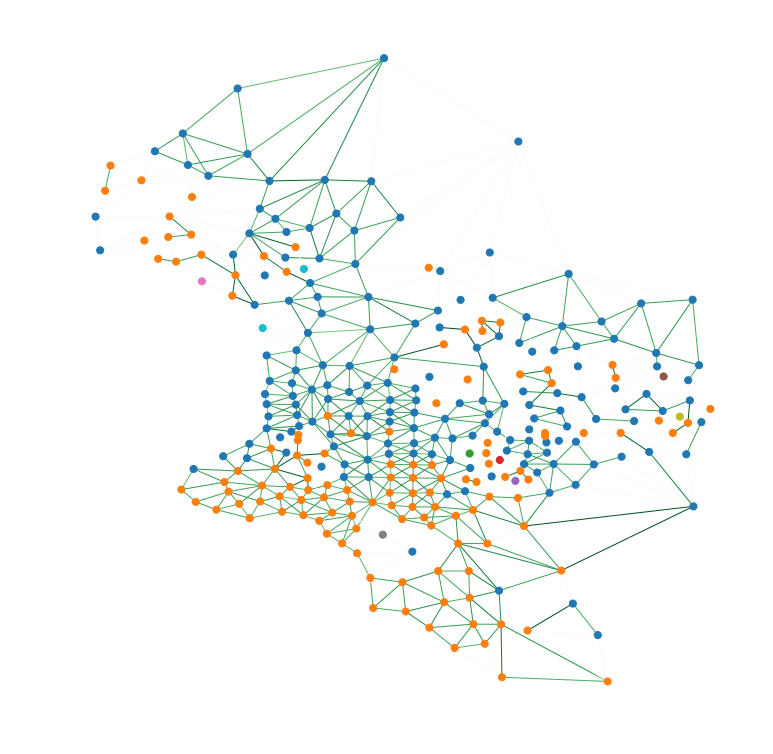

In [176]:
pos = nx.get_node_attributes(gg,'xy')
edges, weights = zip(*nx.get_edge_attributes(gg, 'time3').items())
nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Greens, node_color=list(part9.values()), cmap=plt.cm.tab10)
plt.show()

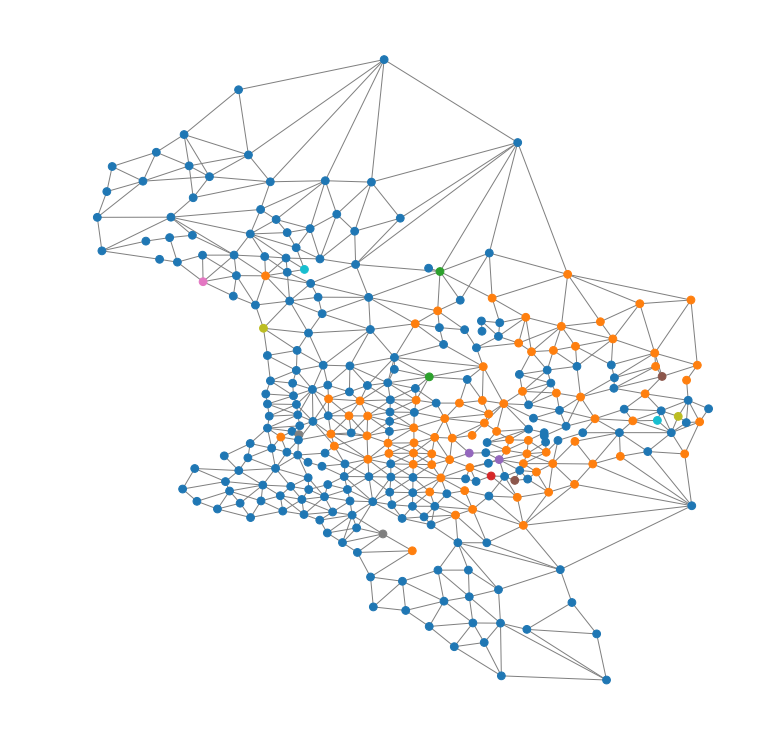

In [502]:
pos = nx.get_node_attributes(gg,'xy')
# edges, weights = zip(*nx.get_edge_attributes(gg, 'time3').items())
nx.draw(gg, pos=pos, node_size=60, width=1, edge_color='grey', node_color=list(part3.values()), cmap=plt.cm.tab10)
# nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Greens, node_color=list(part18.values()), cmap=plt.cm.Set3)
plt.show()

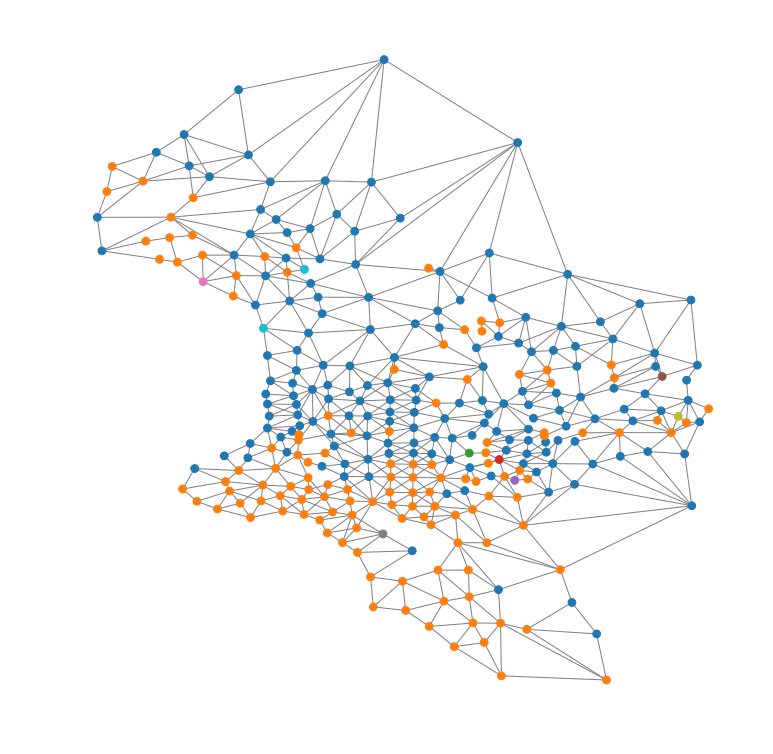

In [501]:
pos = nx.get_node_attributes(gg,'xy')
# edges, weights = zip(*nx.get_edge_attributes(gg, 'time3').items())
nx.draw(gg, pos=pos, node_size=60, width=1, edge_color='grey', node_color=list(part9.values()), cmap=plt.cm.tab10)
# nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Greens, node_color=list(part18.values()), cmap=plt.cm.Set3)
plt.show()

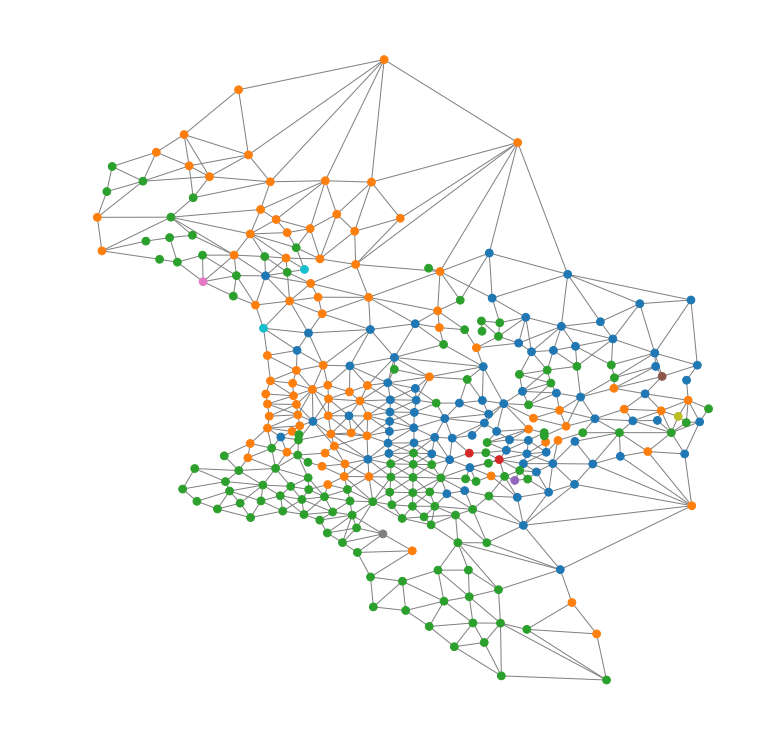

In [500]:
pos = nx.get_node_attributes(gg,'xy')
# edges, weights = zip(*nx.get_edge_attributes(gg, 'time3').items())
nx.draw(gg, pos=pos, node_size=60, width=1, edge_color='grey', node_color=list(part18.values()), cmap=plt.cm.tab10)
# nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Greens, node_color=list(part18.values()), cmap=plt.cm.Set3)
plt.show()

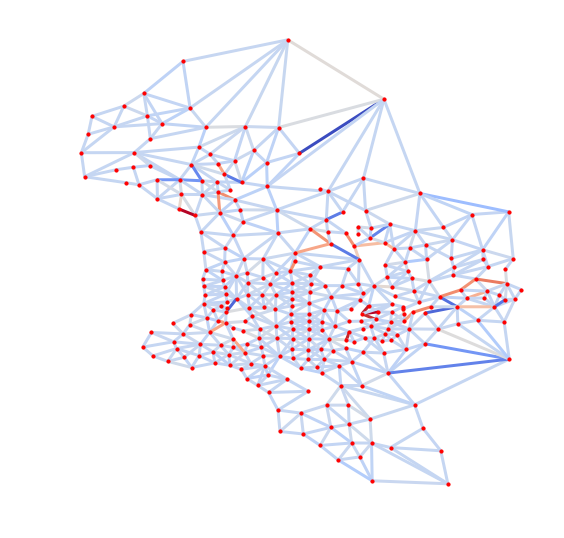

In [575]:
pos = nx.get_node_attributes(gg,'xy')
edges, weights9 = zip(*nx.get_edge_attributes(gg, 'gap9').items())
norm = colors.Normalize(vmin=-10, vmax=10)
nx.draw(gg, pos=pos, node_size=10, edgelist=edges, edge_color=weights9, width=3, edge_cmap=plt.cm.coolwarm, vmin=0, vmax=0)
plt.show()

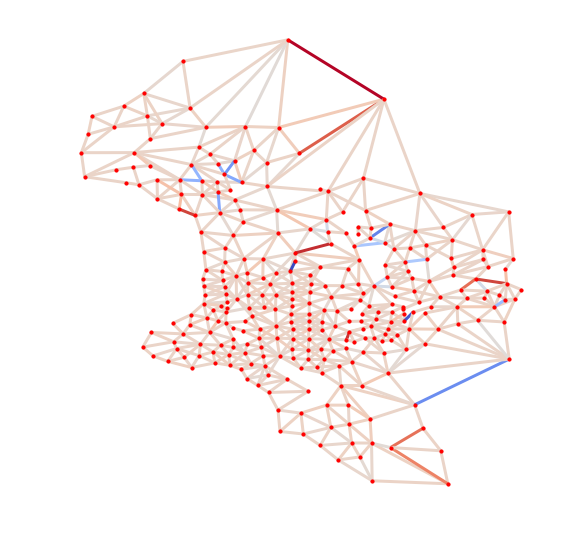

In [583]:
pos = nx.get_node_attributes(gg,'xy')
edges, weights18 = zip(*nx.get_edge_attributes(gg, 'gap18').items())
nx.draw(gg, pos=pos, node_size=10, edgelist=edges, edge_color=weights18, width=3, edge_cmap=plt.cm.coolwarm, vmin=-100, vmax=100)
# nx.draw_networkx_edge_labels(gg, pos=pos, edge_labels=nx.get_edge_attributes(gg, 'gap18'))
plt.show()

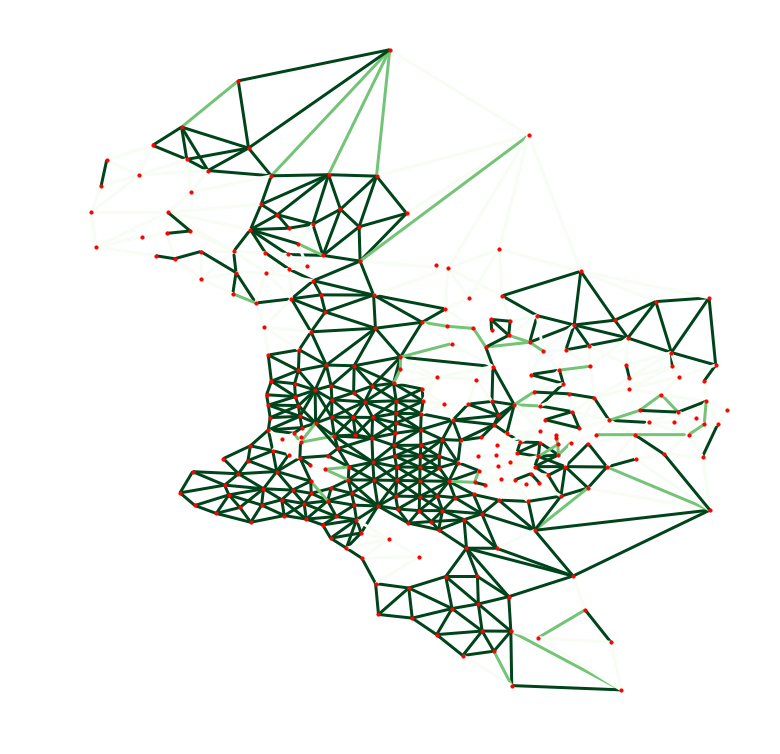

In [689]:
pos = nx.get_node_attributes(gg,'xy')
edges, passage3 = zip(*nx.get_edge_attributes(gg, 'passage3').items())
nx.draw(gg, pos=pos, node_size=10, edgelist=edges, edge_color=passage3, width=3, edge_cmap=plt.cm.Greens)
# nx.draw_networkx_edge_labels(gg, pos=pos, edge_labels=nx.get_edge_attributes(gg, 'gap18'))
plt.show()

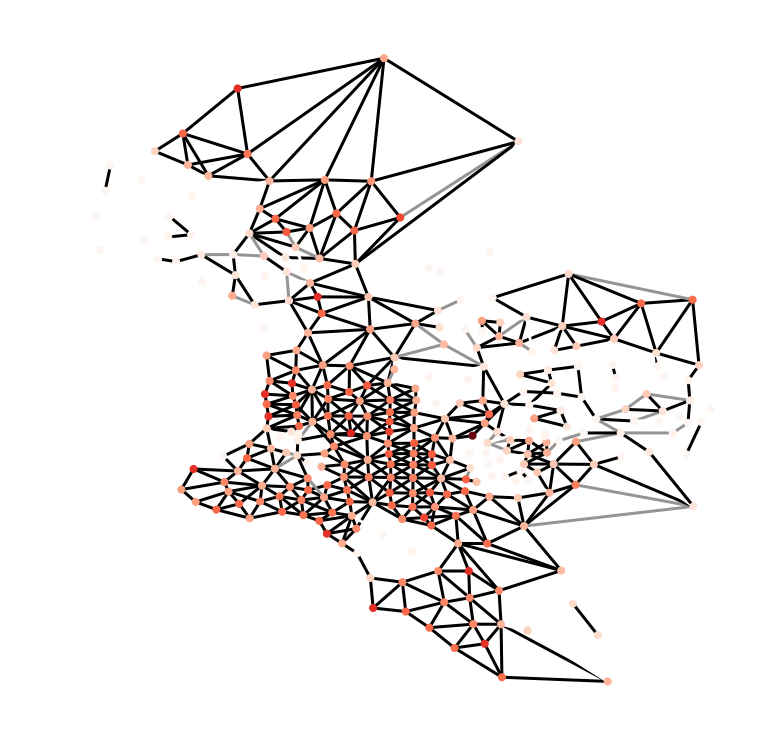

In [20]:
pos = nx.get_node_attributes(gg,'xy')
edges, passage9 = zip(*nx.get_edge_attributes(gg, 'passage9').items())
nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=passage9, width=3, edge_cmap=plt.cm.Greys, node_color=list(cc.values()), cmap=plt.cm.Reds)
# nx.draw_networkx_edge_labels(gg, pos=pos, edge_labels=nx.get_edge_attributes(gg, 'gap18'))
plt.show()

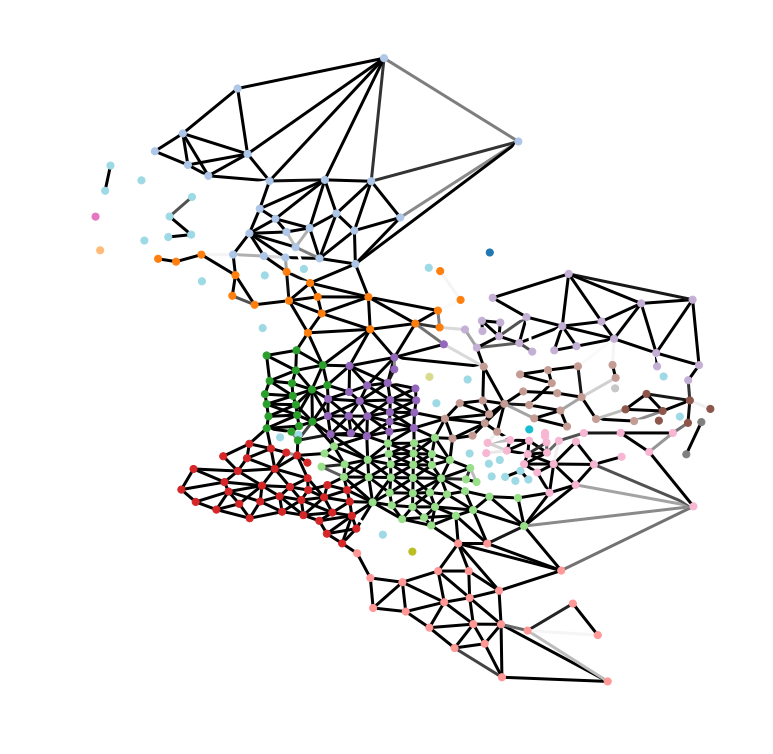

In [62]:
pos = nx.get_node_attributes(gg,'xy')
edges, passageall = zip(*nx.get_edge_attributes(gg, 'passageall').items())
nx.draw(gg, pos=pos, node_size=50, edgelist=edges, edge_color=passageall, width=3, edge_cmap=plt.cm.Greys, node_color=part20, cmap=plt.cm.tab20)
# nx.draw_networkx_edge_labels(gg, pos=pos, edge_labels=nx.get_edge_attributes(gg, 'gap18'))
plt.show()

In [619]:
cnt = 0
for a, b in edges:
    no_data = True
    for i in range(24):
        if all_2016q4.mean_matrix[i][a-1][b-1] > 0:
            no_data = False
    if no_data:
        cnt += 1
cnt

180

In [13]:
passage = np.zeros((300, 300))
for i in range(24):
    passage += all_2016q4.mean_matrix[i] > 0

In [17]:
cc = nx.clustering(gg, weight='passageall')

In [701]:
cc = nx.clustering(gg)

In [174]:
part3 = community.best_partition(gg3)
part9 = community.best_partition(gg9)
part18 = community.best_partition(gg18)

In [71]:
odpairs = [(int(x[0]), int(x[1])) for x in weekday_2016q4.data]

In [505]:
import pandas as pd

In [506]:
df = pd.DataFrame(weekday_2016q4.data[:10])

In [511]:
df.columns = ['sourceid','dstid','hod','mean_travel_time','standard_deviation_travel_time','geometric_mean_travel_time','geometric_standard_deviation_travel_time']
df

sourceid  dstid   hod  mean_travel_time  standard_deviation_travel_time  \
0       1.0    6.0  22.0            792.67                          321.22   
1       1.0    7.0  17.0            707.10                          308.12   
2       2.0    3.0  12.0            394.25                          319.71   
3       2.0    4.0   7.0            633.52                          351.27   
4       2.0    4.0  20.0            511.27                          241.38   
5       2.0    5.0   2.0            190.62                          263.27   
6       2.0    5.0  15.0            227.27                          225.63   
7       2.0    6.0  10.0            316.63                          242.10   
8       2.0    6.0  23.0            345.27                          333.10   
9       2.0    7.0   5.0            533.83                          241.64   

   geometric_mean_travel_time  geometric_standard_deviation_travel_time  
0                      730.87                                      1.50  
1                      652.86                                      1.47  
2                      289.56                                      2.43  
3                      567.15                                      1.55  
4                      467.80                                      1.50  
5                      114.77                                      2.84  
6                      147.00                                      2.83  
7                      219.16                                      2.80  
8                      221.17                                      2.92  
9                      478.17                                      1.64